# Cany Edge Detection

The canny edge detector is an algorithmic approach that uses a multi-stage process to detect a wide range of edges in images</br></br>
Procedures:</br>
&emsp;1. Convert to gray scale</br>
&emsp;2. Gaussian filter</br>
&emsp;3. Gradient estimation</br>
&emsp;&emsp;3.1 Gradient Strength</br>
&emsp;&emsp;3.2 Gradient Direction</br>
&emsp;4. Non-maxima suppression</br>
&emsp;5. Double threshold</br>

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage

In [ ]:
def show_image(imgs, m, n):
    plt.figure(figsize=(10, 20))
    for i, img in enumerate(imgs):
        plt_idx = i+1
        plt.subplot(m, n, plt_idx)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
    plt.show()

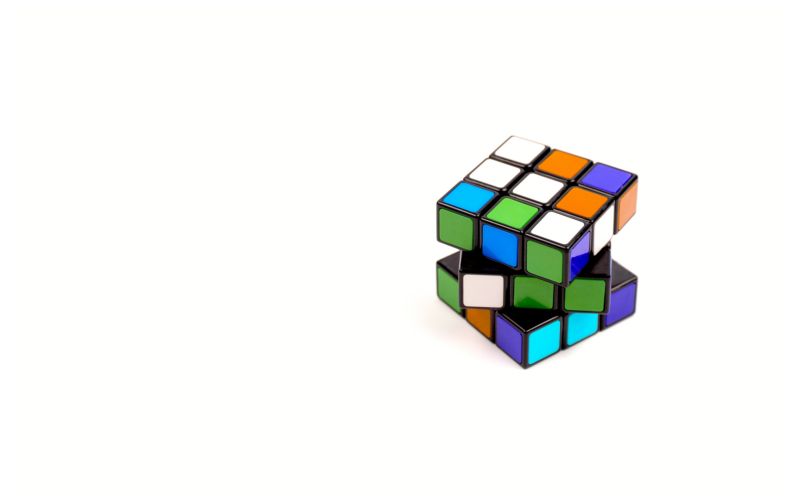

In [ ]:
image_path = '/content/drive/My Drive/Colab Notebooks/CS4722 - Cany Edge Detection/image.jpg'

# Load the image using cv2
image_ori = cv2.imread(image_path)

show_image([image_ori],1,1)

# Convert to Greyscale

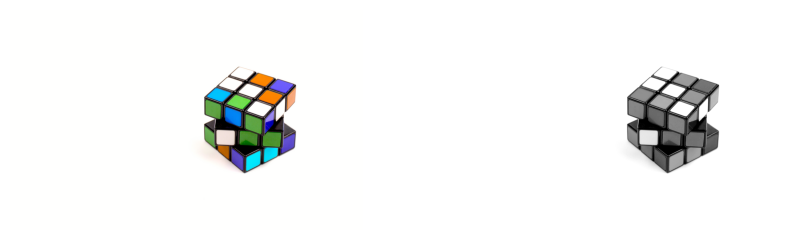

In [ ]:
gray_image = np.dot(image_ori[..., :3], [0.2989, 0.5870, 0.1140])
show_image([image_ori,gray_image],1,2)

#Gaussian filter

In [ ]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

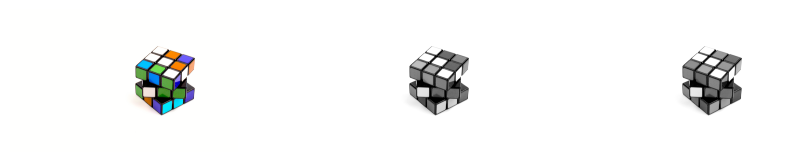

In [ ]:
blurred_image = ndimage.convolve(gray_image, gaussian_kernel(5, 1.4))
show_image([image_ori,gray_image,blurred_image],1,3)


#Gradient Strength

In [31]:
def gradient_filter(img):
    Kx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]], dtype=np.float32)

    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    theta = np.arctan2(Iy, Ix)

    return (G, theta)

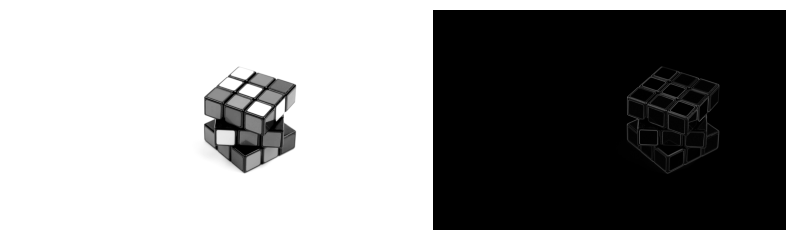

In [33]:
gradientMat, thetaMat = gradient_filter(blurred_image)

show_image([blurred_image, gradientMat], 1, 2)

#Non-maxima suppression

In [34]:
def non_maxima_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M):
        for j in range(1, N):
            try:
                q = 255
                r = 255

               # angle 0
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # angle 45
                elif (22.5 <= angle[i, j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # angle 90
                elif (67.5 <= angle[i, j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # angle 135
                elif (112.5 <= angle[i, j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i, j] >= q) and (img[i, j] >= r):
                    Z[i, j] = img[i, j]
                else:
                    Z[i, j] = 0

            except IndexError as e:
                pass
    return Z

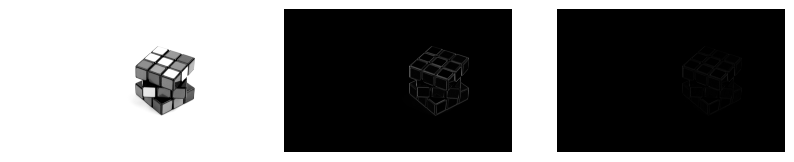

In [35]:
image_non_max = non_maxima_suppression(gradientMat, thetaMat)
show_image([blurred_image, gradientMat, image_non_max], 1, 3)

#Double threshold

In [57]:
def threshold(img,l,h):
    hiThresh = img.max()*h
    loThresh = hiThresh * l

    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)

    strong_i, strong_j = np.where(img >= hiThresh)

    weak_i, weak_j = np.where((img >= loThresh) & (img <= hiThresh))

    res[strong_i, strong_j] = 255
    res[weak_i, weak_j] = 100

    return res

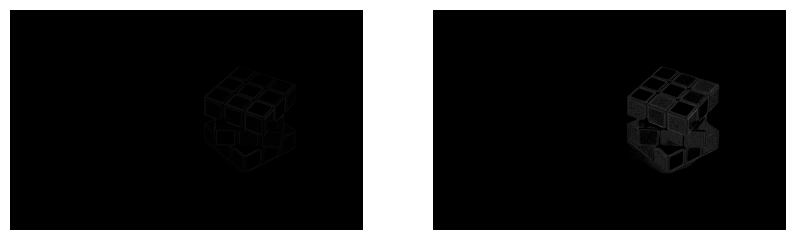

In [52]:
image_final = threshold(image_non_max)

show_image([image_non_max, image_final], 1, 2)

In [60]:
for x in [0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12]:
  for y in [0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19]:
    image_final = threshold(image_non_max,x,y)
    show_image([ image_final], 1, 1)

Output hidden; open in https://colab.research.google.com to view.

From the above iterate I found that 0.09 and 0.15 are fitting very well

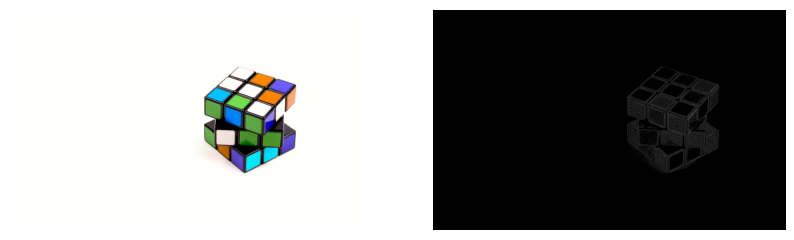

In [62]:
image_final = threshold(image_non_max,0.09,0.15)

show_image([image_ori, image_final], 1, 2)

If we can do edge tracking by hysteresis we can get the edge only.

In [64]:
def hysteresis(img):
    M, N = img.shape

    res = np.copy(img)

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == 100):
                try:
                    if (img[i+1, j-1] == 255) or (img[i+1, j] == 255) or (img[i+1, j+1] == 255) or (img[i, j-1] == 255) or (img[i, j+1] == 255) or (img[i-1, j-1] == 255) or (img[i-1, j] == 255) or (img[i-1, j+1] == 255):
                        res[i, j] = 255
                    else:
                        res[i, j] = 0
                except IndexError as e:
                    pass
    return res

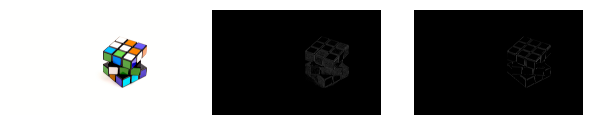

In [65]:
image_hysteresis = hysteresis(image_final)
show_image([image_ori, image_final, image_hysteresis], 1, 4)

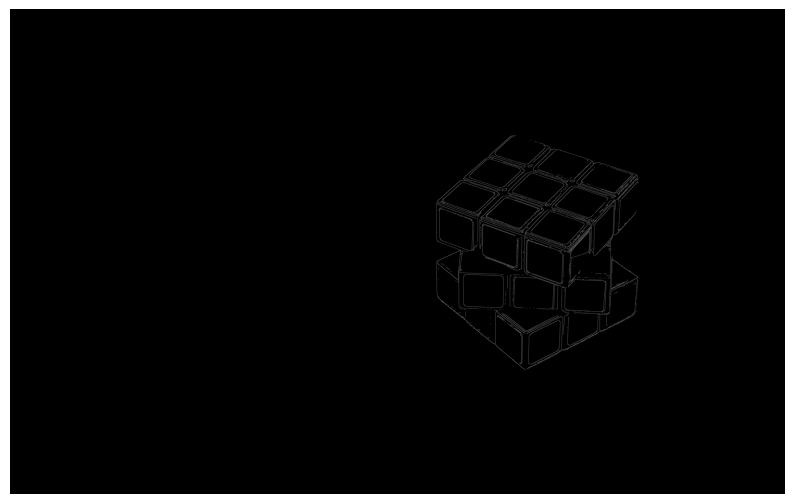

In [66]:
show_image([image_hysteresis], 1, 1)